# Autoencoder Associative Memory Experiments (Figure 3)

## Experiment Overview

This notebook implements the autoencoder comparison experiments for Figure 3 of the paper, evaluating the performance of traditional autoencoders in associative memory tasks and comparing them with the Vector-HaSH method. The experiments test memory recovery capabilities under different storage capacities and noise conditions.

## Key Parameter Reference Table

| Parameter Category | Parameter | Meaning | Typical Value | Description |
|-------------------|-----------|---------|---------------|-------------|
| **Network Architecture** | `Ng` | Number of grid cells | 50 (9+16+25) | Corresponding to 3 different periods of grid cells |
| | `Np` | Number of place cells | 400 | Intermediate layer representation dimension |
| | `Ns` | Sensory input dimension | 3600 | Corresponding to 84×84 grayscale images or binary patterns |
| **Dataset** | `Npatts` | Number of stored patterns | 1-3600 | Range for testing storage capacity variations |
| | `data_features` | miniImageNet features | (3600,) | Preprocessed image feature vectors |
| | `sbook` | Storage codebook | (Npatts, Ns) | Collection of patterns to be stored |
| **Noise Testing** | `test_noise_frac` | Clean test noise | 0.0 | Noise-free baseline test |
| | `test_noise_frac_s` | Sensory layer noise ratio | 0.1 | 10% noise at input layer |
| | `test_noise_frac_p` | Place layer noise ratio | 1.0 | 100% normalized noise at intermediate layer |
| **Training Parameters** | `epochs` | Training epochs | 100-1000 | Autoencoder training iterations |
| | `iters` | Inference iterations | 50 | Iterative steps for memory recovery |
| **Evaluation Metrics** | `get_overlap()` | Cosine similarity | [0,1] | Inner product between normalized vectors |
| | `get_mse()` | Mean squared error | ≥0 | Squared loss for reconstruction error |
| | `mean_p_val` | Intermediate layer activation magnitude | Adaptive | Used for normalizing noise intensity |

## Experimental Design Description

Basic Logic:Use AE to simulate Vector-HaSH

        Vector-Hash                               Autoencoder 
        ------------------                 ----------------------------
        [grid pattern input]              [sensory input: 3600-d vector]
            ↓                                        ↓
        (Wpg: grid → place)                 Dense(Np) encoder (place)
            ↓                                        ↓
        place pattern                    Dense(Ng) ← attractor (grid-like)
            ↓                                        ↓
        (Wgp: place → grid)               Dense(Np)
            ↓                                        ↓
        grid pattern                     Dense(Ns) (reconstructed sensory)
            ↓                                        ↓
        cleanup + fixed point            binarize + cosine overlap

### 1. Autoencoder Architecture
- **Encoder**: Sensory layer (Ns) → Place layer (Np)
- **Decoder**: Place layer (Np) → Grid layer (Ng) → Place layer (Np) → Sensory layer (Ns)
- **Activation function**: tanh (hyperbolic tangent)
- **Optimizer**: Adam
- **Loss function**: Mean squared error

### 2. Three Testing Conditions
1. **Clean test**: No noise input, testing perfect recovery capability
2. **Sensory layer noise**: Adding Gaussian noise at input layer, simulating perceptual noise
3. **Place layer noise**: Adding noise to encoded intermediate representations, simulating neural noise

### 3. Data Type Comparison
- **Random binary patterns**: Purely random generated {-1,+1} patterns
- **miniImageNet**: Feature representations of real image data

### 4. Evaluation Methods
- **Single-step recovery**: Reconstruction quality after one forward pass
- **Iterative recovery**: Final reconstruction quality after multiple iterations
- **Capacity analysis**: Performance curves varying with number of stored patterns

## 1. Module Import and Environment Setup

Import necessary libraries:
- **matplotlib**: Plotting and visualization
- **numpy**: Numerical computation and matrix operations  
- **pandas**: Data processing and analysis
- **tensorflow**: Deep learning framework for building autoencoders
- **sklearn**: Machine learning tools for data preprocessing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm as tqdm
    
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
from tqdm import tqdm as tqdm

### 2.1a Data Preprocessing: Generate miniImageNet Arrays
$\textcolor{red}{Note: This \ cell \ is\ not\  the\ original\ open\ source\ from\ Fiete\ Lab,\ it\ was\ added\ by\ Jini\ Lab\ to\ enhance\ code\ usability.}$

*p.s.:* If you don't want to use `pickle`, then use this cell instead.

**Purpose**: Convert raw Mini-ImageNet dataset to the required .npy format
- First, you are supposed to download [Mini ImageNet](https://aistudio.baidu.com/datasetdetail/167270),This is an address that can be told for downloads both in China and overseas.

**Dataset Structure Analysis**:
- Downloaded Mini-ImageNet location: `D:\Zixing Jia\VectorHaSH-main\miniimagenet\Mini-ImageNet-Dataset`
- Contains: `train/`, `val/`, `test/` folders
- Each folder contains multiple class subdirectories
- Target: Create `miniimagenet_3600_84_84_3.npy` with 3600 images (84×84×3)

**Processing Steps**:
1. **Load images** from the dataset folders
2. **Resize** all images to 84×84 pixels
3. **Normalize** pixel values to [0,1] range
4. **Select** 3600 images total (600 per class for 6 classes)
5. **Save** as numpy array for reproducible experiments

In [3]:
import os
from PIL import Image

def create_miniimagenet_arrays(dataset_path="D:\\Zixing Jia\\VectorHaSH-main\\miniimagenet\\Mini-ImageNet-Dataset"):
    """
    Create miniimagenet_3600_84_84_3.npy and BW_miniimagenet_3600_60_60_full_rank.npy
    from the raw Mini-ImageNet dataset
    
    Args:
        dataset_path: Path to the Mini-ImageNet-Dataset folder
    """
    
    print("🔍 Scanning Mini-ImageNet dataset...")
    
    # Collect all image paths from train, val, test folders
    all_images = []
    all_labels = []
    
    for split in ['train', 'val', 'test']:
        split_path = os.path.join(dataset_path, split)
        if not os.path.exists(split_path):
            print(f"⚠️  Warning: {split_path} not found, skipping...")
            continue
            
        # Get class directories
        class_dirs = [d for d in os.listdir(split_path) 
                     if os.path.isdir(os.path.join(split_path, d))]
        
        for class_name in class_dirs:
            class_path = os.path.join(split_path, class_name)
            # Get all image files
            image_files = [f for f in os.listdir(class_path) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            
            for img_file in image_files:
                all_images.append(os.path.join(class_path, img_file))
                all_labels.append(class_name)
    
    print(f"📊 Found {len(all_images)} images across {len(set(all_labels))} classes")
    
    # Group by class and select 600 images per class for first 6 classes
    class_images = {}
    for img_path, label in zip(all_images, all_labels):
        if label not in class_images:
            class_images[label] = []
        class_images[label].append(img_path)
    
    # Select first 6 classes with sufficient images
    selected_classes = []
    for class_name, img_paths in class_images.items():
        if len(img_paths) >= 600:
            selected_classes.append(class_name)
        if len(selected_classes) >= 6:
            break
    
    if len(selected_classes) < 6:
        print(f"⚠️  Warning: Only found {len(selected_classes)} classes with ≥600 images")
        # Fill with classes that have fewer images
        remaining_classes = [name for name in class_images.keys() if name not in selected_classes]
        selected_classes.extend(remaining_classes[:6-len(selected_classes)])
    
    print(f"✅ Selected classes: {selected_classes}")
    
    # Load and process images
    print("🖼️  Processing images...")
    colored_images = []  # (3600, 84, 84, 3)
    bw_images = []       # (3600, 60, 60)
    
    for i, class_name in enumerate(selected_classes):
        print(f"   Processing class {i+1}/6: {class_name}")
        class_imgs = class_images[class_name]
        
        # Take up to 600 images per class
        selected_imgs = class_imgs[:min(600, len(class_imgs))]
        
        for j, img_path in enumerate(selected_imgs):
            try:
                # Load and resize to 84x84 for colored version
                with Image.open(img_path) as img:
                    # Convert to RGB if necessary
                    if img.mode != 'RGB':
                        img = img.convert('RGB')
                    
                    # Resize to 84x84
                    img_84 = img.resize((84, 84), Image.Resampling.LANCZOS)
                    img_array = np.array(img_84, dtype=np.float32) / 255.0  # Normalize to [0,1]
                    colored_images.append(img_array)
                    
                    # Create 60x60 grayscale version (crop center and convert to BW)
                    # Crop 84x84 -> 60x60 (remove 12 pixels on each side)
                    img_60 = img_84.crop((12, 12, 72, 72))  # (left, top, right, bottom)
                    img_bw = img_60.convert('L')  # Convert to grayscale
                    bw_array = np.array(img_bw, dtype=np.float32) / 255.0
                    bw_images.append(bw_array)
                    
            except Exception as e:
                print(f"❌ Error processing {img_path}: {e}")
                continue
                
            # Progress indicator
            if (j + 1) % 100 == 0:
                print(f"      Processed {j+1}/{len(selected_imgs)} images")
    
    print(f"📊 Successfully processed {len(colored_images)} images")
    
    # Convert to numpy arrays
    if len(colored_images) >= 3600:
        c_miniimagenet = np.array(colored_images[:3600])  # (3600, 84, 84, 3)
        bw_miniimagenet = np.array(bw_images[:3600])      # (3600, 60, 60)
    else:
        print(f"⚠️  Warning: Only got {len(colored_images)} images, padding to 3600...")
        # Pad with repeated images if needed
        while len(colored_images) < 3600:
            colored_images.extend(colored_images[:min(100, 3600-len(colored_images))])
            bw_images.extend(bw_images[:min(100, 3600-len(bw_images))])
        
        c_miniimagenet = np.array(colored_images[:3600])
        bw_miniimagenet = np.array(bw_images[:3600])
    
    print(f"✅ Final array shapes:")
    print(f"   Colored: {c_miniimagenet.shape}")
    print(f"   B&W: {bw_miniimagenet.shape}")
    
    # Save arrays
    print("💾 Saving arrays...")
    np.save("miniimagenet_3600_84_84_3.npy", c_miniimagenet)
    np.save("BW_miniimagenet_3600_60_60_full_rank.npy", bw_miniimagenet)
    
    print("🎉 Successfully created:")
    print("   - miniimagenet_3600_84_84_3.npy")
    print("   - BW_miniimagenet_3600_60_60_full_rank.npy")
    
    return c_miniimagenet, bw_miniimagenet

# Execute the function
try:
    c_miniimagenet, bw_miniimagenet = create_miniimagenet_arrays()
    print("✅ Data preprocessing completed successfully!")
except Exception as e:
    print(f"❌ Error during preprocessing: {e}")
    print("💡 Please check the dataset path and ensure images are accessible.")

🔍 Scanning Mini-ImageNet dataset...
📊 Found 60000 images across 100 classes
✅ Selected classes: ['n01532829', 'n01558993', 'n01704323', 'n01749939', 'n01770081', 'n01843383']
🖼️  Processing images...
   Processing class 1/6: n01532829
      Processed 100/600 images
      Processed 200/600 images
      Processed 300/600 images
      Processed 400/600 images
      Processed 500/600 images
      Processed 600/600 images
   Processing class 2/6: n01558993
      Processed 100/600 images
      Processed 200/600 images
      Processed 300/600 images
      Processed 400/600 images
      Processed 500/600 images
      Processed 600/600 images
   Processing class 3/6: n01704323
      Processed 100/600 images
      Processed 200/600 images
      Processed 300/600 images
      Processed 400/600 images
      Processed 500/600 images
      Processed 600/600 images
   Processing class 4/6: n01749939
      Processed 100/600 images
      Processed 200/600 images
      Processed 300/600 images
      Pro

## 2. Data Loading and Preprocessing

### 2.1 Colored miniImageNet Data Loading
Load preprocessed miniImageNet dataset features that have undergone:

- Image resizing to 84×84 pixels
- Feature extraction and dimensionality reduction
- Normalization processing

In [4]:
##This cell loads minimagenet with colored images

c_miniimagenet = np.load("miniimagenet_3600_84_84_3.npy")
sbook =c_miniimagenet.reshape((3600,84*84*3))
sbook_mean = np.mean(sbook.flatten())
sbook = sbook - sbook_mean
indices = np.concatenate([np.arange(i, 3600, 600) for i in range(600)])
sbook = sbook[indices]
data_features = sbook

### 2.2 Black and White miniImageNet Data Loading
Load black and white version of miniImageNet data:
- Convert color images to grayscale images
- Maintain the same feature dimension (3600 dimensions)
- Remove mean to center data around zero

In [5]:
#This cell loads BW miniimagenet as predominantly used in the paper

sbook = np.load('BW_miniimagenet_3600_60_60_full_rank.npy').reshape((3600,3600))
indices = np.concatenate([np.arange(i, 3600, 600) for i in range(600)])
sbook = sbook[indices]
sbook = sbook - np.mean(sbook.flatten())
data_features=sbook

## 3. Utility Function Definitions

Define core functions for experiments:

### 3.1 Data Corruption Function (`corrupt_p`)
- **Function**: Add random noise to input data
- **Parameters**: 
  - `data`: Input data matrix
  - `p`: Noise intensity (between 0-1)
  - `booktype`: Data type ('cts' continuous, '-11' binary)
- **Usage**: Simulate noise interference in real environments

### 3.2 Evaluation and Processing Functions

#### `get_overlap(x, y)` - Cosine Similarity Calculation
- **Function**: Calculate normalized inner product (cosine similarity) between two vector sets
- **Parameters**: 
  - `normalized=True`: Whether to perform L2 normalization
  - `return_all=False`: Whether to return similarities for all pairs
- **Return**: Average cosine similarity value [0,1], 1 indicates perfect match

#### `cleanup(s, sbook)` - Nearest Neighbor Cleanup
- **Function**: Map blurry output vectors to nearest stored patterns
- **Method**: Find pattern with maximum inner product in codebook
- **Usage**: Discretize continuous outputs to known patterns

#### `binarize(data)` - Binarization Function  
- **Function**: Convert continuous values to binary representation
- **Modes**: 
  - '01': Convert to {0,1}
  - '-11': Convert to {-1,+1}

#### `get_error(x, y)` - L1 Error
- **Function**: Calculate mean absolute error (Manhattan distance)
- **Usage**: Measure pixel-level reconstruction accuracy

#### `get_mse(x, y)` - Mean Squared Error
- **Function**: Calculate mean squared error
- **Usage**: Standard loss function for autoencoders

In [6]:
def corrupt_p(codebook,p=0.1,booktype='01'):
  if p==0.:
    return codebook
  rand_indices = np.sign(np.random.uniform(size=codebook.shape)- p )
  if booktype=='-11':
    return np.multiply(codebook,rand_indices)
  elif booktype=='01':
    return abs(codebook - 0.5*(-rand_indices+1))
  elif booktype=='cts':
    return codebook + np.random.normal(0,1,size=codebook.shape)*p
  else:
    print("codebook should be -11; 01; or cts")
    return 0

def get_overlap(x,y,return_all=False,normalized=True):
  if x.shape != y.shape:
    return "error"
  if normalized:
    x = (x/np.linalg.norm(x,axis=1)[:,None])
    y = (y/np.linalg.norm(y,axis=1)[:,None])
    if return_all:
      return np.einsum('ij,ij->i',x,y)
    else:
      return np.average(np.einsum('ij,ij->i',x,y))
  else:
    if return_all:
      np.einsum('ij,ij->i',x,y)
    else:
      return np.average(np.einsum('ij,ij->i',x,y))

def cleanup(s, sbook):
  idx = np.argmax(sbook@s)
  sclean = sbook[idx,:]
  return sclean

def binarize(data,bin_type='01'):
  if bin_type=='01':
    return 0.5*(np.sign(data - 0.5)+1)
  elif bin_type=='-11':
    return np.sign(data)

def get_error(x,y):
  if x.shape != y.shape:
    return "error"
  return np.sum(abs(x-y))/np.prod(x.shape)

def get_mse(x,y):
  if x.shape != y.shape:
    return "error"
  return np.average((x-y)**2.)

## 4. Experiment One: Random Binary Pattern Storage Capacity Test
---

Basic logic:*Click this markdown cell to read the graph*

           ┌────────────────────────┐
           │      Sensory Input     │   ←   Image (Ns = 3600)
           │    e.g. 84×84 image    │
           └────────────┬───────────┘
                        │
                        ▼
             ┌────────────────────┐
             │   Encoder Dense(Np)│   ← Place cells represent (Np = 400)
             └────────────┬───────┘
                          │
                          ▼
                ┌───────────────————————─┐
                │ decoder Dense(Ng) Grid │   ← Grid cell layed (Ng = 50)，simulate attractor
                └────────┬──────————————─┘
                         │
                         ▼
              ┌───────────────────————————─┐
              │ decoder Dense(Np) (Place ) │   ← Back to  place layer（memory projects agian）
              └────────┬─────────————————──┘
                       │
                       ▼
            ┌────────────────────────┐
            │   Output: Sensory'     │   ← reconstruct image (Ns = 3600)
            └────────────────────────┘

### 4.1 Experimental Design
This experiment uses randomly generated binary patterns `{-1, +1}` to test the associative memory capability of autoencoders.

**Network Architecture Parameters**:
- `Ng = 50` (9+16+25 grid cells)
- `Np = 400` (place cells/intermediate layer dimension)  
- `Ns = 3600` (sensory input dimension)
- `Npatts = 1-3600` (number of stored patterns, varying parameter)

**Training Setup**:
- Training epochs: 100 epochs
- Optimizer: Adam
- Loss function: Mean squared error

### 4.2 Three Testing Conditions

#### Test 1: Clean Recovery (test_noise_frac = 0.0)
- No noise input, testing recovery capability under ideal conditions
- Evaluate basic associative memory performance of autoencoder

#### Test 2: Sensory Layer Noise (test_noise_frac_s = 0.1) 
- Add 10% bit-flip noise at input layer
- Simulate interference during perceptual process

#### Test 3: Place Layer Noise (test_noise_frac_p = 1.0)
- Add normalized Gaussian noise to encoded intermediate representations
- Noise intensity = `mean_p_val * standard normal distribution / sqrt(Np)`
- Simulate noise during neural transmission

### 4.3 Iterative Recovery Process
- **Single-step recovery**: Results after one encoding-decoding pass
- **Iterative recovery**: Steady-state results after 50 iterations
- **Purpose**: Observe whether autoencoders can improve recovery quality through iteration

In [ ]:

Npatts_list = np.arange(1,3601,500)
nruns = 1

first_clean_overlap_list = np.zeros((Npatts_list.shape[0],nruns))#In the initial noise-free condition, after one round of autoencoding, there is overlap.
final_clean_overlap_list = np.zeros((Npatts_list.shape[0],nruns))#After multiple iterations, the overlap after recall is completed.

first_noisy_overlap_list = np.zeros((Npatts_list.shape[0],nruns))#Input (sensory) with noise conditions.
final_noisy_overlap_list = np.zeros((Npatts_list.shape[0],nruns))

first_noisy_p_overlap_list = np.zeros((Npatts_list.shape[0],nruns))#The situation of adding noise after encoding (place layer).
final_noisy_p_overlap_list = np.zeros((Npatts_list.shape[0],nruns))

verbose=False

for nidx in (range(nruns)):
  for idx,Npatts in enumerate(tqdm(Npatts_list)):
    if verbose:
      print("xxxxx nidx = "+str(nidx))
      print("xxxxx idx = "+str(idx))
      print("xxxxx Npatts = "+str(Npatts))
    Ng=9+16+25
    Np=400
    Ns=3600
    # Npatts=200
    data_shape = Ns
    test_noise_frac=0.0
    test_noise_frac_s=0.1
    test_noise_frac_p=1.0

    sbook = np.sign(np.random.uniform(size=(Npatts,Ns))-0.5)
    #We just want to test the memory capability of the autoencoder, so it doesn't matter whether we use real images or not.

    sperm = sbook[np.random.permutation(Npatts)]
    true_data = sperm[:Npatts]   

    #Autoencoder model below defined with encoder as being s>p and decoder as p>g>p>s so that noise injected after encoder is p noise
    class Autoencoder(Model):
      def __init__(self, Np,Ng,Ns):
        super(Autoencoder, self).__init__()
        self.Np = Np
        self.Ns = Ns
        self.Ng = Ng
        self.encoder = tf.keras.Sequential([
          layers.Dense(Np, activation='tanh'),
          # layers.Dense(Ng, activation='tanh'),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(Ng, activation='tanh'),
          layers.Dense(Np, activation='tanh'),
          layers.Dense(Ns, activation='tanh')
        ])

      def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    autoencoder = Autoencoder(Np,Ng,Ns)

    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

    autoencoder.fit(true_data, true_data, epochs=100, verbose=0);
    

    if verbose: print("-------------Testing--1----------------")
    if verbose: print("Testing noise percentage = "+str(test_noise_frac))
    cts_corrupt = corrupt_p(true_data,p=0,booktype='cts')

    encoded_data = autoencoder.encoder(cts_corrupt[:Npatts]).numpy()
    decoded_data = autoencoder.decoder(encoded_data).numpy()


    decoded_data1 = binarize(np.copy(decoded_data),bin_type='-11')
    #1.Simulating the discrete behaviour of neurons discharging in the brain as "either activated or not activated".
    #2.#This is the source of the values for `first_clean_overlap`` and the like.
    
    # decoded_data1 = np.copy(decoded_data)

    #####Simulated multi-round memory clearing (core)#####
    iters=50
    for _ in range(iters):
        encoded_data = autoencoder.encoder(decoded_data).numpy()
        decoded_data = autoencoder.decoder(encoded_data).numpy()
    decoded_data = binarize(decoded_data,bin_type='-11') #This is the source of the values for `final_clean_overlap`` and the like.
    mean_p_val = np.average(np.linalg.norm(encoded_data,axis=1))

    if verbose:
        print("Npatts = "+str(Npatts))
        # print("Initial error: " + str(get_mse(true_data[:,:data_shape], cts_corrupt[:Npatts,:data_shape])))
        # print("error after one timestep: " + str(get_mse(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
        # print("error after iteration: " + str(get_mse(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

        print("overlap after one timestep: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
        print("overlap after iteration: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

    first_clean_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])
    final_clean_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])

    
    if verbose: print("-------------Testing--2----------------")
    if verbose: print("Testing noise percentage = "+str(test_noise_frac_s))
    
    cts_corrupt = corrupt_p(true_data,p=test_noise_frac_s,booktype='-11')

    encoded_data = autoencoder.encoder(cts_corrupt[:Npatts]).numpy()
    decoded_data = autoencoder.decoder(encoded_data).numpy()
    decoded_data1 = binarize(np.copy(decoded_data),bin_type='-11')
    # decoded_data1 = np.copy(decoded_data)
    iters=50
    for _ in range(iters):
      encoded_data = autoencoder.encoder(decoded_data).numpy()
      decoded_data = autoencoder.decoder(encoded_data).numpy()
    decoded_data = binarize(decoded_data,bin_type='-11')

    if verbose:
      print("Np = "+str(Np))
      print("Ns = "+str(Ns))
      print("Ng = "+str(Ng))
      print("Npatts = "+str(Npatts))


      print("Initial overlap: " + str(get_overlap(true_data[:,:data_shape], cts_corrupt[:Npatts,:data_shape])))
      print("overlap after one timestep: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
      print("overlap after iteration: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

    first_noisy_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])
    final_noisy_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])

    
    if verbose: print("-------------Testing--3----------------")
    if verbose: print("Testing noise percentage = "+str(test_noise_frac_p))
    cts_corrupt = corrupt_p(true_data,p=0,booktype='cts')

    encoded_data = autoencoder.encoder(cts_corrupt[:Npatts]).numpy()
    encoded_data = encoded_data + test_noise_frac_p*mean_p_val*np.random.normal(0,1,encoded_data.shape)/np.sqrt(Np)
    decoded_data = autoencoder.decoder(encoded_data).numpy()
    decoded_data1 = binarize(np.copy(decoded_data),bin_type='-11')
    # decoded_data1 = np.copy(decoded_data)
    iters=50
    for _ in range(iters):
      encoded_data = autoencoder.encoder(decoded_data).numpy()
      decoded_data = autoencoder.decoder(encoded_data).numpy()
    decoded_data = binarize(decoded_data,bin_type='-11')

    if verbose:
      print("Np = "+str(Np))
      print("Ns = "+str(Ns))
      print("Ng = "+str(Ng))
      print("Npatts = "+str(Npatts))


      print("Initial error: " + str(get_mse(true_data[:,:data_shape], cts_corrupt[:Npatts,:data_shape])))
      print("error after one timestep: " + str(get_mse(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
      print("error after iteration: " + str(get_mse(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

      print("Initial overlap: " + str(get_overlap(true_data[:,:data_shape], cts_corrupt[:Npatts,:data_shape])))
      print("overlap after one timestep: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
      print("overlap after iteration: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

    first_noisy_p_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])
    final_noisy_p_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])

    

100%|██████████| 8/8 [03:45<00:00, 28.20s/it]


### Varying Npatts BW miniimagenet sbook

## 5. Experiment Two: Real Image Data Storage Capacity Test
---

$\textcolor{red}{Note: This \ original \ code \ will \ throw \ an \ error \ , \ which \ may \ stem \ from \ different \ versions \ of \ tqdm.  }$

The difference between 4 and 5 is that 5 uses real images.

### 5.1 Experimental Design Changes
This experiment uses real miniImageNet image features to test autoencoder performance on natural data.

**Key Differences**:
- **Data source**: Real image features vs random binary patterns
- **Training intensity**: 1000 epochs vs 100 epochs (real data is more complex)
- **Data preprocessing**: `data_features - np.mean(data_features)` (mean removal)
- **Noise calculation**: Based on data standard deviation rather than fixed ratio

### 5.2 Modified Noise Injection Methods

#### Sensory Layer Noise (Revised Version)
```python
sbook_std = np.std(sbook.flatten())
cts_corrupt = true_data + test_noise_frac_s * sbook_std * np.random.normal(0,1,true_data.shape)
```
- Use actual standard deviation of data to set noise level
- Better conform to noise characteristics of real data
- Maintain reasonable ratio between noise and signal

#### Place Layer Noise (Consistent)
- Same normalization method as Experiment One
- Normalized based on average norm of intermediate representations

### 5.3 Challenges of Real Data
- **Structural complexity**: Natural images have complex statistical structure
- **Non-randomness**: Correlations exist between image features
- **Training difficulty**: Requires more training epochs to learn complex patterns
- **Noise sensitivity**: Real data may be more sensitive to noise

In [ ]:

Npatts_list = np.arange(1,3601,50)
nruns = 3
first_clean_overlap_list = np.zeros((Npatts_list.shape[0],nruns))
final_clean_overlap_list = np.zeros((Npatts_list.shape[0],nruns))

first_noisy_overlap_list = np.zeros((Npatts_list.shape[0],nruns))
final_noisy_overlap_list = np.zeros((Npatts_list.shape[0],nruns))

first_noisy_p_overlap_list = np.zeros((Npatts_list.shape[0],nruns))
final_noisy_p_overlap_list = np.zeros((Npatts_list.shape[0],nruns))

verbose=False

for nidx in (range(nruns)):
  ######## Note:the next line is original code, but it will thorw an error.So I changed it to tqdm(Npatts_list) ########
  ######## for idx,Npatts in enumerate(tqdm.tqdm(Npatts_list)):
  for idx,Npatts in enumerate(tqdm(Npatts_list)):
    if verbose:
      print("xxxxx nidx = "+str(nidx))
      print("xxxxx idx = "+str(idx))
      print("xxxxx Npatts = "+str(Npatts))
    Ng=9+16+25
    Np=400
    Ns=3600#84*84*3   ### Adjust accordingly if using colored images or BW images
    # Npatts=200
    data_shape = Ns
    test_noise_frac=0.0
    test_noise_frac_s=0.1
    test_noise_frac_p=1.0

    sbook = data_features - np.mean(data_features.flatten())

    sperm = sbook[np.random.permutation(Npatts)]
    true_data = sperm[:Npatts]   

    #Autoencoder model below defined with encoder as being s>p and decoder as p>g>p>s so that noise injected after encoder is p noise
    class Autoencoder(Model):
      def __init__(self, Np,Ng,Ns):
        super(Autoencoder, self).__init__()
        self.Np = Np
        self.Ns = Ns
        self.Ng = Ng
        self.encoder = tf.keras.Sequential([
          layers.Dense(Np, activation='tanh'),
          # layers.Dense(Ng, activation='tanh'),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(Ng, activation='tanh'),
          layers.Dense(Np, activation='tanh'),
          layers.Dense(Ns, activation='tanh')
        ])

      def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    autoencoder = Autoencoder(Np,Ng,Ns)

    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

    autoencoder.fit(true_data, true_data, epochs=1000, verbose=0);
    

    if verbose: print("-------------Testing--1----------------")
    if verbose: print("Testing noise percentage = "+str(test_noise_frac))
    cts_corrupt = corrupt_p(true_data,p=0,booktype='cts')

    encoded_data = autoencoder.encoder(cts_corrupt[:Npatts]).numpy()
    decoded_data = autoencoder.decoder(encoded_data).numpy()
    decoded_data1 = np.copy(decoded_data)
    iters=50
    for _ in range(iters):
        encoded_data = autoencoder.encoder(decoded_data).numpy()
        decoded_data = autoencoder.decoder(encoded_data).numpy()
    mean_p_val = np.average(np.linalg.norm(encoded_data,axis=1))

    if verbose:
        print("Npatts = "+str(Npatts))
        # print("Initial error: " + str(get_mse(true_data[:,:data_shape], cts_corrupt[:Npatts,:data_shape])))
        # print("error after one timestep: " + str(get_mse(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
        # print("error after iteration: " + str(get_mse(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

        print("overlap after one timestep: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
        print("overlap after iteration: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

    first_clean_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])
    final_clean_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])

    
    if verbose: print("-------------Testing--2----------------")
    if verbose: print("Testing noise percentage = "+str(test_noise_frac_s))
    
    sbook_std = np.std(sbook.flatten())
    cts_corrupt = true_data + test_noise_frac_s*sbook_std*np.random.normal(0,1,true_data.shape)
    ## mean_s_value = np.average(np.linalg.norm(sbook,axis=1))
    ## cts_corrupt = true_data + test_noise_frac_s*mean_s_value*np.random.normal(0,1,true_data.shape)/np.sqrt(Ns)

    encoded_data = autoencoder.encoder(cts_corrupt[:Npatts]).numpy()
    decoded_data = autoencoder.decoder(encoded_data).numpy()
    decoded_data1 = np.copy(decoded_data)
    iters=50
    for _ in range(iters):
      encoded_data = autoencoder.encoder(decoded_data).numpy()
      decoded_data = autoencoder.decoder(encoded_data).numpy()
    
    if verbose:
      print("Np = "+str(Np))
      print("Ns = "+str(Ns))
      print("Ng = "+str(Ng))
      print("Npatts = "+str(Npatts))


      print("Initial overlap: " + str(get_overlap(true_data[:,:data_shape], cts_corrupt[:Npatts,:data_shape])))
      print("overlap after one timestep: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
      print("overlap after iteration: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

    first_noisy_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])
    final_noisy_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])

    
    if verbose: print("-------------Testing--3----------------")
    if verbose: print("Testing noise percentage = "+str(test_noise_frac_p))
    cts_corrupt = corrupt_p(true_data,p=0,booktype='cts')

    encoded_data = autoencoder.encoder(cts_corrupt[:Npatts]).numpy()
    encoded_data = encoded_data + test_noise_frac_p*mean_p_val*np.random.normal(0,1,encoded_data.shape)/np.sqrt(Np)
    decoded_data = autoencoder.decoder(encoded_data).numpy()
    decoded_data1 = np.copy(decoded_data)
    iters=50
    for _ in range(iters):
      encoded_data = autoencoder.encoder(decoded_data).numpy()
      decoded_data = autoencoder.decoder(encoded_data).numpy()
    
    if verbose:A
    print("Np = "+str(Np))
    print("Ns = "+str(Ns))
    print("Ng = "+str(Ng))
    print("Npatts = "+str(Npatts))


    print("Initial error: " + str(get_mse(true_data[:,:data_shape], cts_corrupt[:Npatts,:data_shape])))
    print("error after one timestep: " + str(get_mse(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
    print("error after iteration: " + str(get_mse(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

    print("Initial overlap: " + str(get_overlap(true_data[:,:data_shape], cts_corrupt[:Npatts,:data_shape])))
    print("overlap after one timestep: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
    print("overlap after iteration: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

    first_noisy_p_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])
    final_noisy_p_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])

    

100%|██████████| 72/72 [5:26:06<00:00, 271.75s/it]  


### Plotting/saving

## 6. Result Analysis and Visualization

### 6.1 Performance Metric Comparison
This section plots and saves experimental results, comparing associative memory performance under different conditions:

**Plot Content**:
- **X-axis**: Number of stored patterns (Npatts) - logarithmic scale
- **Y-axis**: Cosine similarity - logarithmic scale  
- **Curve Types**:
  - `clean, single/final`: Single-step/iterative recovery under noise-free conditions
  - `noisy s, single/final`: Single-step/iterative recovery under sensory layer noise
  - `noisy p, single/final`: Single-step/iterative recovery under place layer noise

**Error bars**: Show standard deviation across multiple runs, evaluating result stability

### 6.2 Expected Observations
1. **Capacity limitation**: Recovery quality decreases as number of stored patterns increases
2. **Noise effects**: Different types of noise have varying impacts on performance
3. **Iterative improvement**: Whether multiple iterations can improve recovery quality
4. **Data type differences**: Performance comparison between real data vs random data

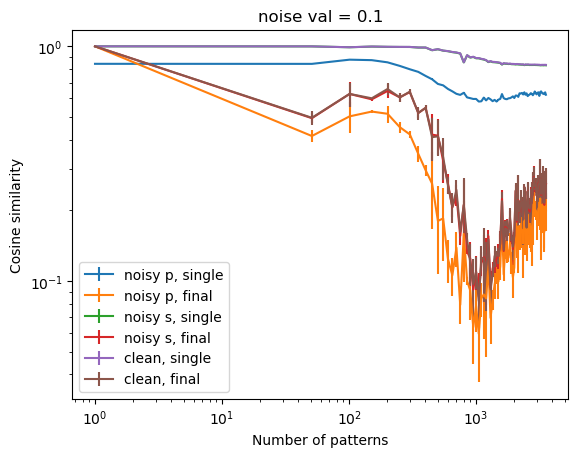

In [9]:
# plt.plot(Npatts_list,np.average(first_noisy_overlap_list,axis=1), label='noisy, single')
# plt.plot(Npatts_list,np.average(final_noisy_overlap_list,axis=1), label='noisy, final')
# plt.plot(Npatts_list,np.average(first_clean_overlap_list,axis=1), label='clean, single')
# plt.plot(Npatts_list,np.average(final_clean_overlap_list,axis=1), label='clean, final')
plt.errorbar(Npatts_list,np.average(first_noisy_p_overlap_list,axis=1),yerr=np.std(first_noisy_overlap_list,axis=1), label='noisy p, single')
plt.errorbar(Npatts_list,np.average(final_noisy_p_overlap_list,axis=1),yerr=np.std(final_noisy_overlap_list,axis=1), label='noisy p, final')

plt.errorbar(Npatts_list,np.average(first_noisy_overlap_list,axis=1),yerr=np.std(first_noisy_overlap_list,axis=1), label='noisy s, single')
plt.errorbar(Npatts_list,np.average(final_noisy_overlap_list,axis=1),yerr=np.std(final_noisy_overlap_list,axis=1), label='noisy s, final')

plt.errorbar(Npatts_list,np.average(first_clean_overlap_list,axis=1),yerr=np.std(first_clean_overlap_list,axis=1), label='clean, single')
plt.errorbar(Npatts_list,np.average(final_clean_overlap_list,axis=1),yerr=np.std(final_clean_overlap_list,axis=1), label='clean, final')
plt.xlabel('Number of patterns')
plt.ylabel('Cosine similarity')
plt.title('noise val = '+str(test_noise_frac_s))
plt.xscale('log');
plt.yscale('log');
plt.legend()
# plt.savefig("overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+"_nruns_"+str(nruns)+"_miniimagenet_BW_perm_2.0_noisy_s_p.png")

### 6.3 miniImageNet Results Saving
Save detailed result data from miniImageNet black and white image experiments

In [ ]:
np.save("first_clean_overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+"_nruns_"+str(nruns)+"_miniimagenet_BW_perm_2.0_noisy_s_p.npy", first_clean_overlap_list)
np.save("final_clean_overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+"_nruns_"+str(nruns)+"_miniimagenet_BW_perm_2.0_noisy_s_p.npy", final_clean_overlap_list)
np.save("first_noisy_overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+"_nruns_"+str(nruns)+"_miniimagenet_BW_perm_2.0_noisy_s_p.npy", first_noisy_overlap_list)
np.save("final_noisy_overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+"_nruns_"+str(nruns)+"_miniimagenet_BW_perm_2.0_noisy_s_p.npy", final_noisy_overlap_list)
np.save("first_noisy_p_overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+"_nruns_"+str(nruns)+"_miniimagenet_BW_perm_2.0_noisy_s_p.npy", first_noisy_p_overlap_list)
np.save("final_noisy_p_overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+"_nruns_"+str(nruns)+"_miniimagenet_BW_perm_2.0_noisy_s_p.npy", final_noisy_p_overlap_list)


np.save("Npatts_list_miniimagenet_BW_perm_2.0_noisy_s_p.npy", Npatts_list)


### 6.4 Random Binary Pattern Results Saving
Save detailed result data from random binary pattern experiments, with filenames including key experimental parameters

In [ ]:
np.save("first_clean_overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+"_nruns_"+str(nruns)+"_random_binary_0.1_sflip_1.0_pnoise.npy", first_clean_overlap_list)
np.save("final_clean_overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+"_nruns_"+str(nruns)+"_random_binary_0.1_sflip_1.0_pnoise.npy", final_clean_overlap_list)
np.save("first_noisy_overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+"_nruns_"+str(nruns)+"_random_binary_0.1_sflip_1.0_pnoise.npy", first_noisy_overlap_list)
np.save("final_noisy_overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+"_nruns_"+str(nruns)+"_random_binary_0.1_sflip_1.0_pnoise.npy", final_noisy_overlap_list)
np.save("first_noisy_p_overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+"_nruns_"+str(nruns)+"_random_binary_0.1_sflip_1.0_pnoise.npy", first_noisy_p_overlap_list)
np.save("final_noisy_p_overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+"_nruns_"+str(nruns)+"_random_binary_0.1_sflip_1.0_pnoise.npy", final_noisy_p_overlap_list)


np.save("Npatts_list_random_binary_0.1_sflip_1.0_pnoise.npy", Npatts_list)

### 6.5 Performance Curve Plotting
Generate final performance comparison plots showing autoencoder associative memory performance under different conditions

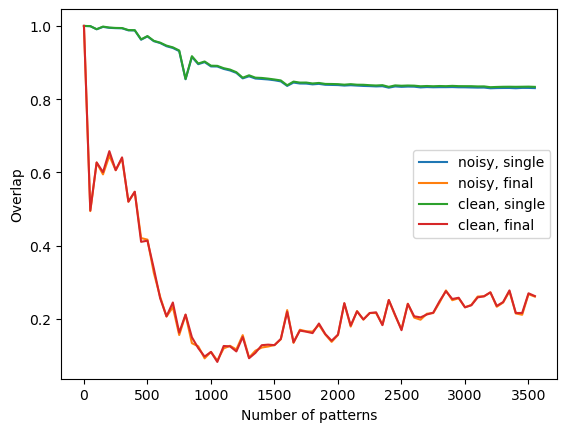

In [10]:
# plt.figure(figsize=(10,8))
plt.plot(Npatts_list,np.average(first_noisy_overlap_list,axis=1), label='noisy, single')
plt.plot(Npatts_list,np.average(final_noisy_overlap_list,axis=1), label='noisy, final')
plt.plot(Npatts_list,np.average(first_clean_overlap_list,axis=1), label='clean, single')
plt.plot(Npatts_list,np.average(final_clean_overlap_list,axis=1), label='clean, final')
# plt.errorbar(Npatts_list,np.average(first_noisy_overlap_list,axis=1),yerr=np.std(first_noisy_overlap_list,axis=1), label='noisy, single')
# plt.errorbar(Npatts_list,np.average(final_noisy_overlap_list,axis=1),yerr=np.std(final_noisy_overlap_list,axis=1), label='noisy, final')
# plt.errorbar(Npatts_list,np.average(first_clean_overlap_list,axis=1),yerr=np.std(first_clean_overlap_list,axis=1), label='clean, single')
# plt.errorbar(Npatts_list,np.average(final_clean_overlap_list,axis=1),yerr=np.std(final_clean_overlap_list,axis=1), label='clean, final')
plt.xlabel('Number of patterns')
plt.ylabel('Overlap')
plt.legend()
plt.savefig("overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+"_nruns_"+str(nruns)+".pdf")

### 6.6 Historical Results Reloading
Reload previously saved experimental results for analysis, suitable for comparing different parameter settings

In [ ]:
Ng=18
Np=300
Ns=816
first_clean_overlap_list = np.load("first_clean_overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+".npy")
final_clean_overlap_list = np.load("final_clean_overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+".npy")
first_noisy_overlap_list = np.load("first_noisy_overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+".npy")
final_noisy_overlap_list = np.load("final_noisy_overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+".npy")
Npatts_list = np.load("Npatts_list.npy")

## iterative increase (not used in paper, qualitatively similar results to above)
 

## 7. Supplementary Experiment: Iterative Capacity Growth Test

### 7.1 Experimental Design Philosophy
This is a supplementary experiment not used in the paper but with theoretical value. It tests the change patterns of autoencoder performance when the number of stored patterns increases incrementally.

### 7.2 Differences from Main Experiments
- **Training strategy**: Incremental training vs fixed quantity training
- **Capacity testing**: Progressive loading vs one-time loading  
- **Expected results**: Observe specific patterns of performance degradation

### 7.3 Scientific Significance
- Understand **catastrophic forgetting** phenomenon in autoencoders
- Analyze critical points of **capacity saturation**
- Compare effects of **batch learning** vs **online learning**

In [ ]:
import tqdm
Npatts_list = np.arange(1,3601,50)
dNpatts_list = np.diff(Npatts_list)
np.insert(dNpatts_list,0,Npatts_list[0])
# Npatts_list = np.logspace(2,np.log10(3600),25).astype('int')[::-1]
nruns = 3
first_clean_overlap_list = np.zeros((Npatts_list.shape[0],nruns))
final_clean_overlap_list = np.zeros((Npatts_list.shape[0],nruns))
# first_clean_overlap_not_norm_list = np.zeros((Npatts_list.shape[0],nruns))
# final_clean_overlap_not_norm_list = np.zeros((Npatts_list.shape[0],nruns))
# first_clean_l1_list = np.zeros((Npatts_list.shape[0],nruns))
# final_clean_l1_list = np.zeros((Npatts_list.shape[0],nruns))
# first_clean_mse_list = np.zeros((Npatts_list.shape[0],nruns))
# final_clean_mse_list = np.zeros((Npatts_list.shape[0],nruns))

first_noisy_overlap_list = np.zeros((Npatts_list.shape[0],nruns))
final_noisy_overlap_list = np.zeros((Npatts_list.shape[0],nruns))

first_noisy_p_overlap_list = np.zeros((Npatts_list.shape[0],nruns))
final_noisy_p_overlap_list = np.zeros((Npatts_list.shape[0],nruns))

verbose=False

for nidx in (range(nruns)):
  Npatts = 0
  Ng=9+16+25
  Np=400
  Ns=3600#84*84*3
  # Npatts=200
  data_shape = Ns
  test_noise_frac=0.0
  test_noise_frac_s=1.
  test_noise_frac_p=1.

  sbook = np.sign(np.random.uniform(size=(max(Npatts_list),Ns))-0.5)

  # sbook = data_features - np.mean(data_features.flatten())


  #sperm = sbook[np.random.permutation(3600)]
  # true_data = sperm[:Npatts]   #data_features[:Npatts]   #double_train_data_cts  #train_data_cts   #noise_aug_train_data  #sbook # bin_train[:Npatts] #

  class Autoencoder(Model):
    def __init__(self, Np,Ng,Ns):
      super(Autoencoder, self).__init__()
      self.Np = Np
      self.Ns = Ns
      self.Ng = Ng
      self.encoder = tf.keras.Sequential([
        layers.Dense(Np, activation='tanh'),
        # layers.Dense(Ng, activation='tanh'),
      ])
      self.decoder = tf.keras.Sequential([
        layers.Dense(Ng, activation='tanh'),
        layers.Dense(Np, activation='tanh'),
        layers.Dense(Ns, activation='tanh')
      ])

    def call(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

  autoencoder = Autoencoder(Np,Ng,Ns)

  autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

  for idx,dNpatts in enumerate(tqdm.tqdm(dNpatts_list)):
    if verbose:
      print("xxxxx nidx = "+str(nidx))
      print("xxxxx idx = "+str(idx))
      print("xxxxx Npatts = "+str(Npatts))

    train_data = sbook[Npatts:Npatts+dNpatts]
    autoencoder.fit(train_data, train_data, epochs=3000, verbose=0);
    Npatts = Npatts + dNpatts


    # if verbose: print("-------------Testing--1----------------")
    # if verbose: print("Testing noise percentage = "+str(test_noise_frac))
    true_data = sbook[:Npatts]
    cts_corrupt = corrupt_p(true_data,p=0,booktype='cts')

    encoded_data = autoencoder.encoder(cts_corrupt[:Npatts]).numpy()
    decoded_data = autoencoder.decoder(encoded_data).numpy()
    #decoded_data1 = binarize(np.copy(decoded_data),bin_type='-11')
    decoded_data1 = np.copy(decoded_data)
    iters=50
    for _ in range(iters):
      encoded_data = autoencoder.encoder(decoded_data).numpy()
      decoded_data = autoencoder.decoder(encoded_data).numpy()
    #decoded_data = binarize(decoded_data,bin_type='-11')
    mean_p_val = np.average(np.linalg.norm(encoded_data,axis=1))

    if verbose:
      print("Npatts = "+str(Npatts))
      # print("Initial error: " + str(get_mse(true_data[:,:data_shape], cts_corrupt[:Npatts,:data_shape])))
      # print("error after one timestep: " + str(get_mse(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
      # print("error after iteration: " + str(get_mse(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

      # print("Initial overlap: " + str(get_overlap(true_data[:,:data_shape], cts_corrupt[:Npatts,:data_shape])))
      print("overlap after one timestep: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
      print("overlap after iteration: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

    first_clean_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])
    final_clean_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])

    # first_clean_overlap_not_norm_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape],normalized=False)
    # final_clean_overlap_not_norm_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape],normalized=False)

    # first_clean_l1_list[idx,nidx]=get_error(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])
    # final_clean_l1_list[idx,nidx]=get_error(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])

    # first_clean_mse_list[idx,nidx]=get_mse(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])
    # final_clean_mse_list[idx,nidx]=get_mse(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])

    if verbose: print("-------------Testing--2----------------")
    if verbose: print("Testing noise percentage = "+str(test_noise_frac_s))
    # cts_corrupt = corrupt_p(true_data,p=test_noise_frac_s,booktype='cts')

    mean_s_value = np.average(np.linalg.norm(true_data,axis=1))
    cts_corrupt = true_data + test_noise_frac_s*mean_s_value*np.random.normal(0,1,true_data.shape)/np.sqrt(Ns)

    encoded_data = autoencoder.encoder(cts_corrupt[:Npatts]).numpy()
    decoded_data = autoencoder.decoder(encoded_data).numpy()
    #decoded_data1 = binarize(np.copy(decoded_data),bin_type='-11')
    decoded_data1 = np.copy(decoded_data)
    iters=50
    for _ in range(iters):
      encoded_data = autoencoder.encoder(decoded_data).numpy()
      decoded_data = autoencoder.decoder(encoded_data).numpy()
    #decoded_data = binarize(decoded_data,bin_type='-11')

    if verbose:
      print("Np = "+str(Np))
      print("Ns = "+str(Ns))
      print("Ng = "+str(Ng))
      print("Npatts = "+str(Npatts))


      print("Initial error: " + str(get_mse(true_data[:,:data_shape], cts_corrupt[:Npatts,:data_shape])))
      print("error after one timestep: " + str(get_mse(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
      print("error after iteration: " + str(get_mse(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

      print("Initial overlap: " + str(get_overlap(true_data[:,:data_shape], cts_corrupt[:Npatts,:data_shape])))
      print("overlap after one timestep: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
      print("overlap after iteration: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

    first_noisy_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])
    final_noisy_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])

    # first_noisy_overlap_not_norm_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape],normalized=False)
    # final_noisy_overlap_not_norm_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape],normalized=False)

    # first_noisy_l1_list[idx,nidx]=get_error(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])
    # final_noisy_l1_list[idx,nidx]=get_error(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])

    # first_noisy_mse_list[idx,nidx]=get_mse(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])
    # final_noisy_mse_list[idx,nidx]=get_mse(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])

    if verbose: print("-------------Testing--3----------------")
    if verbose: print("Testing noise percentage = "+str(test_noise_frac_p))
    cts_corrupt = corrupt_p(true_data,p=0,booktype='cts')

    encoded_data = autoencoder.encoder(cts_corrupt[:Npatts]).numpy()
    encoded_data = encoded_data + test_noise_frac_p*mean_p_val*np.random.normal(0,1,encoded_data.shape)/np.sqrt(Np)
    decoded_data = autoencoder.decoder(encoded_data).numpy()
    #decoded_data1 = binarize(np.copy(decoded_data),bin_type='-11')
    decoded_data1 = np.copy(decoded_data)
    iters=50
    for _ in range(iters):
      encoded_data = autoencoder.encoder(decoded_data).numpy()
      decoded_data = autoencoder.decoder(encoded_data).numpy()
    #decoded_data = binarize(decoded_data,bin_type='-11')

    if verbose:
      print("Np = "+str(Np))
      print("Ns = "+str(Ns))
      print("Ng = "+str(Ng))
      print("Npatts = "+str(Npatts))


      print("Initial error: " + str(get_mse(true_data[:,:data_shape], cts_corrupt[:Npatts,:data_shape])))
      print("error after one timestep: " + str(get_mse(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
      print("error after iteration: " + str(get_mse(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

      print("Initial overlap: " + str(get_overlap(true_data[:,:data_shape], cts_corrupt[:Npatts,:data_shape])))
      print("overlap after one timestep: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
      print("overlap after iteration: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

    first_noisy_p_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])
    final_noisy_p_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])

    # first_noisy_overlap_not_norm_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape],normalized=False)
    # final_noisy_overlap_not_norm_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape],normalized=False)

    # first_noisy_l1_list[idx,nidx]=get_error(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])
    # final_noisy_l1_list[idx,nidx]=get_error(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])

    # first_noisy_mse_list[idx,nidx]=get_mse(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])
    # final_noisy_mse_list[idx,nidx]=get_mse(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])


In [ ]:
# plt.plot(Npatts_list,np.average(first_noisy_overlap_list,axis=1), label='noisy, single')
# plt.plot(Npatts_list,np.average(final_noisy_overlap_list,axis=1), label='noisy, final')
# plt.plot(Npatts_list,np.average(first_clean_overlap_list,axis=1), label='clean, single')
# plt.plot(Npatts_list,np.average(final_clean_overlap_list,axis=1), label='clean, final')
plt.errorbar(Npatts_list,np.average(first_noisy_p_overlap_list,axis=1),yerr=np.std(first_noisy_overlap_list,axis=1), label='noisy p, single')
plt.errorbar(Npatts_list,np.average(final_noisy_p_overlap_list,axis=1),yerr=np.std(final_noisy_overlap_list,axis=1), label='noisy p, final')

plt.errorbar(Npatts_list,np.average(first_noisy_overlap_list,axis=1),yerr=np.std(first_noisy_overlap_list,axis=1), label='noisy s, single')
plt.errorbar(Npatts_list,np.average(final_noisy_overlap_list,axis=1),yerr=np.std(final_noisy_overlap_list,axis=1), label='noisy s, final')
plt.errorbar(Npatts_list,np.average(first_clean_overlap_list,axis=1),yerr=np.std(first_clean_overlap_list,axis=1), label='clean, single')
plt.errorbar(Npatts_list,np.average(final_clean_overlap_list,axis=1),yerr=np.std(final_clean_overlap_list,axis=1), label='clean, final')
plt.xlabel('Number of patterns')
plt.ylabel('Cosine similarity')
plt.title('noise val = '+str(test_noise_frac_s))
# plt.plot([1,10],[1,0.1],'k--')
# plt.xscale('log')
# plt.yscale('log')
plt.legend()

In [ ]:
# sbook_std = np.std(sbook.flatten())
# # scorrupt_test = corrupt_p(sbook,p=0.2,booktype='cts')
# scorrupt_test = sbook + np.random.normal(0,1,sbook.shape)*1*sbook_std
# #scorrupt_test = 0.5*(scorrupt_test+1)

# sbookf = sbook[:Npatts].reshape((Npatts,60,60))
# scorrupt_test = np.copy(sbookf)
# scorrupt_test[:,:,20:40] = np.random.normal(0,0.1,(Npatts,60,20))
# scorrupt_test = scorrupt_test.reshape((Npatts,3600))

scorrupt_test = corrupt_p(sbook,p=0.1,booktype='-11')

encoded_data = autoencoder.encoder(scorrupt_test[:Npatts]).numpy()

# encoded_data = encoded_data + 0.5*mean_p_val*np.random.normal(0,1,encoded_data.shape)/np.sqrt(Np)
decoded_data = autoencoder.decoder(encoded_data).numpy()
decoded_data1 = np.copy(decoded_data)
iters=100
ovp_ite = np.zeros(iters)
for i in tqdm(range(iters)):
    encoded_data = autoencoder.encoder(decoded_data).numpy()
    decoded_data = autoencoder.decoder(encoded_data).numpy()
    ovp_ite[i] = get_overlap(sbook[:Npatts],decoded_data)



## 8. Experimental Summary and Key Findings

### 8.1 Autoencoder vs Vector-HaSH Comparison Points

**Autoencoder Characteristics**:
- ✅ **Simple training**: Standard gradient descent optimization
- ✅ **Flexible architecture**: Can design complex network structures
- ❌ **Limited storage capacity**: Performance degrades rapidly as pattern count increases
- ❌ **Noise sensitive**: Sensitive to input and intermediate layer noise
- ❌ **Iterative convergence**: Requires multiple iterations to reach steady state

**Vector-HaSH Advantages**:
- ✅ **High storage capacity**: Utilizes periodic structure of grid cells
- ✅ **Noise robust**: Biologically-inspired competition mechanism provides noise resistance
- ✅ **Fast convergence**: Single step or few steps for recovery
- ✅ **Biologically plausible**: Based on hippocampal neuroscience principles

